## What is Sentiment Analysis?

Sentiment Analysis is a process of extracting opinions that have different polarities. By polarities, we mean positive, negative or neutral. It is also known as opinion mining and polarity detection. With the help of sentiment analysis, you can find out the nature of opinion that is reflected in documents, websites, social media feed, etc. Sentiment Analysis is a type of classification where the data is classified into different classes. These classes can be binary in nature (positive or negative) or, they can have multiple classes (happy, sad, angry, etc.).
![](https://d1sjtleuqoc1be.cloudfront.net/wp-content/uploads/2019/04/25112909/shutterstock_1073953772.jpg)

## What files do I need?

You'll need train.csv, test.csv and sample_submission.csv.

## What should I expect the data format to be?

Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)

## What am I predicting?

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### Files
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

### Columns

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)



# 1) import library & packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abida\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abida\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
#default theme
sns.set(context='notebook', style='darkgrid', palette='colorblind', font='sans-serif', font_scale=1, rc=None)
matplotlib.rcParams['figure.figsize'] =[8,8]
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'sans-serif'

# 2) load data & analysis

In [10]:
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')
sub = pd.read_csv('Data/Sample.csv')

In [11]:
print(train.shape,test.shape)

(70000, 3) (30000, 2)


In [12]:
train.head()

ID                                               text  label
0  13P0QT0  3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...     -1
1  SKCLXCJ       cha3eb fey9elkoum menghir ta7ayoul ou kressi     -1
2  V1TVXIJ  bereau degage nathef ya slim walahi ya7chiw fi...     -1
3  U0TTYY8                                          ak slouma      1
4  68DX797  entom titmanou lina a7na 3iid moubarik a7na ch...     -1

In [13]:
train.describe(include='all')

ID           text         label
count     70000          70000  70000.000000
unique    70000          70000           NaN
top     GIM0FJ3  iniik il koll           NaN
freq          1              1           NaN
mean        NaN            NaN      0.127771
std         NaN            NaN      0.973889
min         NaN            NaN     -1.000000
25%         NaN            NaN     -1.000000
50%         NaN            NaN      1.000000
75%         NaN            NaN      1.000000
max         NaN            NaN      1.000000

### finding missing values

In [14]:
missing_values=train.isnull().sum()
percent_missing = train.isnull().sum()/train.shape[0]*100

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing %
ID                   0                0.0
text                 0                0.0
label                0                0.0

In [15]:
#Remove redundant samples
train=train.drop_duplicates(subset=['text', 'label'], keep='first')
train.shape

(70000, 3)

We have 92 redundants sapmles in our dataset

In [16]:
train.label.value_counts()

 1    38239
-1    29295
 0     2466
Name: label, dtype: int64

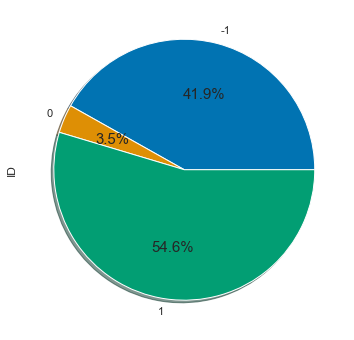

In [17]:
fig = plt.figure(figsize=(8,6))
train.groupby('label').ID.count().plot.pie(autopct='%1.1f%%',shadow=True)
plt.show()

labels are not balanced

In [18]:
# Numbers of word for each sapmle in train & test data
train['text_length'] = train.text.apply(lambda x: len(x.split()))
test['text_length'] = test.text.apply(lambda x: len(x.split()))


In [19]:
train['text_length'].describe()

count    70000.000000
mean         9.837443
std         14.818509
min          2.000000
25%          4.000000
50%          6.000000
75%         11.000000
max       1721.000000
Name: text_length, dtype: float64

In [20]:
test['text_length'].describe()

count    30000.000000
mean        10.272033
std         15.074307
min          2.000000
25%          4.000000
50%          6.000000
75%         11.000000
max        955.000000
Name: text_length, dtype: float64

Max number of words in all data is 31 and min is 1!

In [21]:
def plot_word_count(df, data_name):
  sns.distplot(df['text_length'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

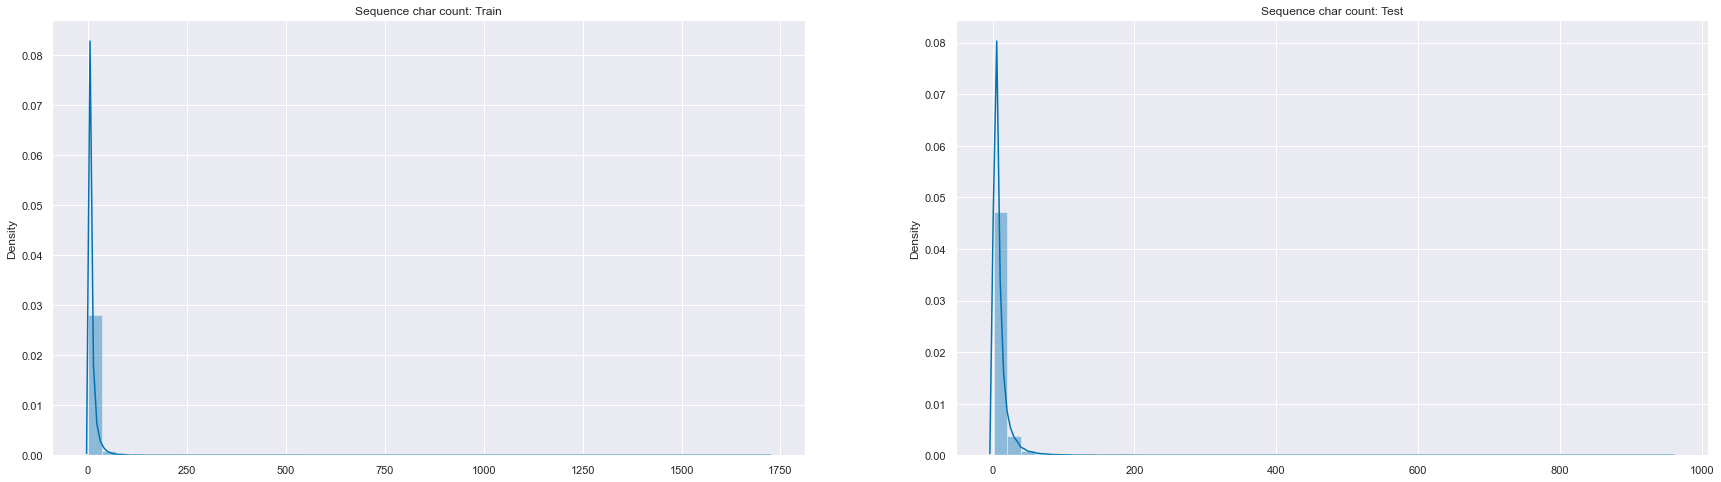

In [22]:
#ig = plt.figure(figsize=(16,6))
#plt.hist(train["text_length"], bins = 30)
#plt.show()
plt.subplot(1, 2, 1)
plot_word_count(train, 'Train')

plt.subplot(1, 2, 2)
plot_word_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [23]:
# collecting all words in single list
list_= []
for i in train.text:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)

In [24]:
len(vocabulary)

186481

We have 31480 different words in our train data

In [25]:
def create_corpus(df,target):
    corpus=[]
    
    for x in df[df['label']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<AxesSubplot:>

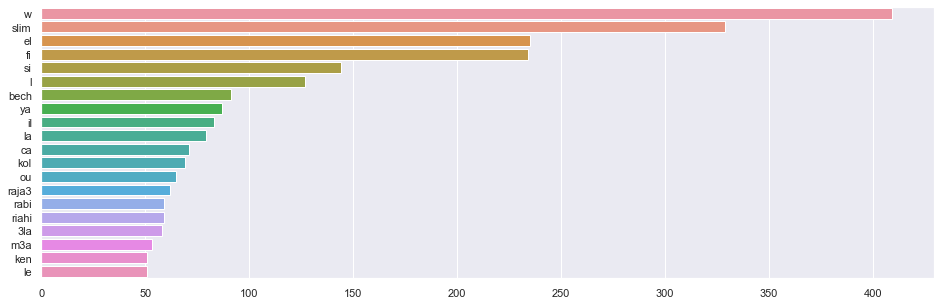

In [26]:
#most frequent 20 words when label == 0 
import collections
allWords=create_corpus(train,target=0)
vocabulary= set(allWords)
vocabulary_list= list(vocabulary)

plt.figure(figsize=(16,5))
counter=collections.Counter(allWords)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
  x.append(word)
  y.append(count)
sns.barplot(x=y,y=x)

<AxesSubplot:>

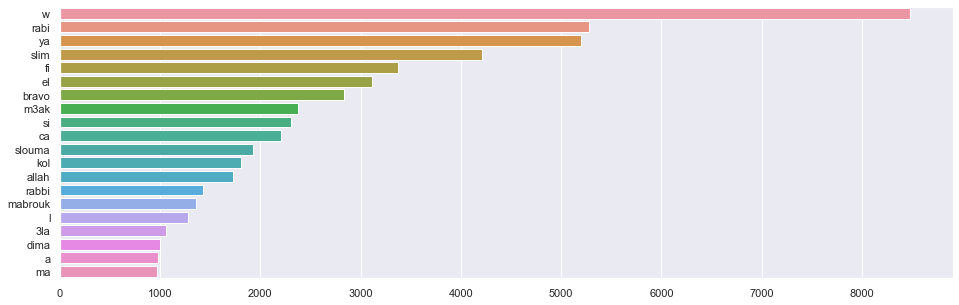

In [27]:
#most frequent 20 words when label == 1 
import collections
allWords=create_corpus(train,target=1)
vocabulary= set(allWords)
vocabulary_list= list(vocabulary)

plt.figure(figsize=(16,5))
counter=collections.Counter(allWords)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
  x.append(word)
  y.append(count)
sns.barplot(x=y,y=x)

# 3) Data Cleaning

### Removing Punctuations

In [28]:
#List of punctuations and we will remove them from our corpus
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
#for  example
text='hi !! whats up bro :) i hope you enjoy with me '
"".join([char for char in text if char not in string.punctuation])

'hi  whats up bro  i hope you enjoy with me '

### Removing Numbers

In [30]:
#for example 
text='hey 4 look 333 at me0 58999632'
re.sub('[0-9]', '', text)

'hey  look  at me '

### Removing Stopwords

In [31]:
#list of stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [32]:
#for example
text='hey this is me and I am here to help you  '
tokens = word_tokenize(text)
tokens=[word for word in tokens if word not in stopwords.words('english')]
' '.join(tokens)

'hey I help'

### Now let's Build a function that clean our data

I just added lower function in order to lowercase all words and stemming

In [33]:
pstem = PorterStemmer()
def clean_text(text):
    text= text.lower()
    text= re.sub('[0-9]', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens=[pstem.stem(word) for word in tokens]
    #tokens=[word for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)
    return text

In [34]:
clean_text("hey I am here # ! looks 4 GOOD can't see you!")

'hey i am here look good cant see you'

In [35]:
train["clean"]=train["text"].apply(clean_text)
test["clean"]=test["text"].apply(clean_text)

In [36]:
#Let's see the effect of cleaning
train[["text","clean"]].head()

text  \
0  3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...   
1       cha3eb fey9elkoum menghir ta7ayoul ou kressi   
2  bereau degage nathef ya slim walahi ya7chiw fi...   
3                                          ak slouma   
4  entom titmanou lina a7na 3iid moubarik a7na ch...   

                                               clean  
0  sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi ou...  
1          chaeb feyelkoum menghir taayoul ou kressi  
2  bereau degag nathef ya slim walahi yachiw fih ...  
3                                          ak slouma  
4  entom titman lina ana iid moubarik ana chab lm...

In [37]:
# collecting all words in single list
list_= []
for i in train.clean:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)
len(vocabulary)

171170

we reduced our data from 31480 unique words to 19920

In [38]:
tfidf = TfidfVectorizer(sublinear_tf=True,max_features=60000, min_df=1, norm='l2',  ngram_range=(1,2))
features = tfidf.fit_transform(train.clean)
features.shape

(70000, 60000)

In [39]:
features_test = tfidf.transform(test.clean)

## 4) machine leaning algorithm

In [40]:
#split data into 4 parts with same distribution of classes.
skf = StratifiedKFold(n_splits=5, random_state=48, shuffle=True)
accuracy=[] # list contains the accuracy for each fold
n=1
y=train['label']

In [41]:
for trn_idx, test_idx in skf.split(features, y):
  start_time = time()
  X_tr,X_val=features[trn_idx],features[test_idx]
  y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
  # model= LGBMClassifier(max_depth=3, learning_rate=0.001, n_estimators=1000)
  model= LogisticRegression(max_iter=2000,C=3)
  #model=MultinomialNB(alpha=0.5)
  # model=svm.SVC(max_iter=2000)
  model.fit(X_tr,y_tr)
  s = model.predict(X_val)
  sub[str(n)]= model.predict(features_test) 
  
  accuracy.append(accuracy_score(y_val, s))
  print((time() - start_time)/60,accuracy[n-1])
  n+=1

0.36301230589548744 0.789
0.428362782796224 0.7992857142857143
0.4138940533002218 0.7896428571428571
0.43750865856806437 0.7943571428571429
0.40069079399108887 0.7892142857142858


In [42]:
accuracy

[0.789,
 0.7992857142857143,
 0.7896428571428571,
 0.7943571428571429,
 0.7892142857142858]

In [43]:
np.mean(accuracy)*100

79.23

## 5) Evaluating Model on Validation Set

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
pred_valid_y = model.predict(X_val)
print(classification_report(y_val, pred_valid_y ))

              precision    recall  f1-score   support

          -1       0.76      0.79      0.77      5859
           0       0.68      0.12      0.21       494
           1       0.82      0.83      0.82      7647

    accuracy                           0.79     14000
   macro avg       0.75      0.58      0.60     14000
weighted avg       0.79      0.79      0.78     14000



In [45]:
print(confusion_matrix(y_val, pred_valid_y ))

[[4625   16 1218]
 [ 216   61  217]
 [1271   13 6363]]


# Submission

In [46]:
sub.head(10)

ID  label  1  2  3  4  5
0  2DDHQW9      0  1  1  1  1  1
1  5HY6UEY      0 -1 -1 -1 -1 -1
2  ATNVUJX      0  1  1  1  1  1
3  Q9XYVOQ      0  1  1  1  1  1
4  TOAHLRH      0  1  1  1  1  1
5  D6P9HYI      0 -1 -1 -1 -1 -1
6  D57GZJX      0 -1 -1 -1 -1 -1
7  4DVGZU6      0 -1 -1 -1 -1 -1
8  M8TVCAH      0 -1 -1 -1 -1 -1
9  QM1GHHJ      0  1  1  1  1  1

In [47]:
test_df = pd.read_csv('Data/Test.csv')
test_df['label'] = sub['2'] 
test_df=test_df[['ID','label']]
test_df['label']=test_df['label'].apply(lambda x : int(x))

In [48]:
test_df.to_csv('Submissions/submission.csv',index=False)